# Anomaly Detection

```
Usage Instructions:
1. First, launch the backend:
   python3 launch_backend.py --config configs/api_configs/api_config_air_quality.yaml

2. Then run this notebook
```

In [1]:
import json
import os
from dataclasses import dataclass
from datetime import datetime
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
@dataclass
class AnomalyMetadata:
    """
    Metadata container for each detected anomaly.
    """

    timestamp: Any
    score: float
    original_value: float
    predicted_value: float
    group_metadata: Dict[str, Any]


def convert_json_to_anomaly_detection_format(stream_synthesis_response):
    json_results, concurrent_results = (
        stream_synthesis_response.json()["results"],
        stream_synthesis_response.json()["concurrent_results"],
    )
    # Convert JSON back to AnomalyMetadata objects
    results = {}
    for kpi, kpi_results in json_results.items():
        results[kpi] = {}
        for anomaly_type, type_results in kpi_results.items():
            results[kpi][anomaly_type] = {}
            for group_key, anomalies in type_results.items():
                results[kpi][anomaly_type][group_key] = [
                    AnomalyMetadata(
                        timestamp=pd.Timestamp(a["timestamp"]),
                        score=float(a["score"]),
                        original_value=float(a["original_value"]),
                        predicted_value=float(a["predicted_value"]),
                        group_metadata=a["group_metadata"],
                    )
                    for a in anomalies
                ]
    return results, concurrent_results

In [3]:
SYNTHEFY_PACKAGE_BASE = os.environ.get("SYNTHEFY_PACKAGE_BASE", "/home/synthefy/synthefy-package")

Load the streaming data from JSON file

In [4]:
with open(
    f"{SYNTHEFY_PACKAGE_BASE}/examples/air_quality_data_stream.json",
    "r",
) as f:
    input_data = json.load(f)

In [5]:
config_filepath = f"{SYNTHEFY_PACKAGE_BASE}/examples/configs/preprocessing_configs/config_air_quality_preprocessing.json"

In [6]:
with open(config_filepath, "r") as f:
    config = json.load(f)
timeseries_cols = config["timeseries"]["cols"]

In [7]:
SYNTHEFY_DATASETS_BASE = os.environ.get("SYNTHEFY_DATASETS_BASE", "/home/synthefy/datasets")
DATASET_NAME = "air_quality"
df = pd.read_parquet(
    f"{SYNTHEFY_DATASETS_BASE}/{DATASET_NAME}/{config['filename'].split('/')[-1]}",
    engine="pyarrow",
)

In [8]:
timestamps_col = config["timestamps_col"]
group_labels_cols = config["group_labels"]["cols"]
frequency_type = config["anomaly_detection"]["frequency"]["type"]

required_cols = (
    timestamps_col + group_labels_cols + timeseries_cols
)
df = df[required_cols]
df[timestamps_col[0]] = df[timestamps_col[0]].astype(str)

Process each time series column through the anomaly detection API

In [9]:
df_reset = df.reset_index(drop=True)

In [10]:
stream_synthesis_response = requests.post(
    f"http://127.0.0.1:8000/api/v2/anomaly_detection/{DATASET_NAME}/stream",
    json=json.loads(df_reset.to_json()),
    timeout=600
)

In [11]:
stream_synthesis_response.json()

{'results': {'PM2.5': {'peak': {'Aotizhongxin': [{'timestamp': '2016-02-08T02:00:00',
      'score': 10.39884179996749,
      'original_value': 898.0,
      'predicted_value': 80.17649450814093,
      'group_metadata': {'station': 'Aotizhongxin'}},
     {'timestamp': '2016-02-08T03:00:00',
      'score': 8.194243455899871,
      'original_value': 713.0,
      'predicted_value': 77.54901319151134,
      'group_metadata': {'station': 'Aotizhongxin'}},
     {'timestamp': '2017-01-28T06:00:00',
      'score': 7.763765109351186,
      'original_value': 697.0,
      'predicted_value': 107.15776185238953,
      'group_metadata': {'station': 'Aotizhongxin'}},
     {'timestamp': '2017-01-28T05:00:00',
      'score': 7.5241198062991215,
      'original_value': 713.0,
      'predicted_value': 109.73537363543443,
      'group_metadata': {'station': 'Aotizhongxin'}},
     {'timestamp': '2017-01-28T04:00:00',
      'score': 7.434008016455008,
      'original_value': 682.0,
      'predicted_value': 1

In [12]:
results, concurrent_results = convert_json_to_anomaly_detection_format(stream_synthesis_response)

Plot each timeseries and its anomalies

In [13]:
df['station'].unique()

array(['Dongsi', 'Huairou', 'Changping', 'Shunyi', 'Gucheng',
       'Nongzhanguan', 'Dingling', 'Wanliu', 'Guanyuan', 'Aotizhongxin',
       'Tiantan', 'Wanshouxigong'], dtype=object)

In [14]:
timeseries_cols

['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# Plot Anomalies

In [15]:
from synthefy_pkg.anomaly_detection.utils.plotting_utils import plot_group_anomalies

## Plot for station="Aotizhongxin"

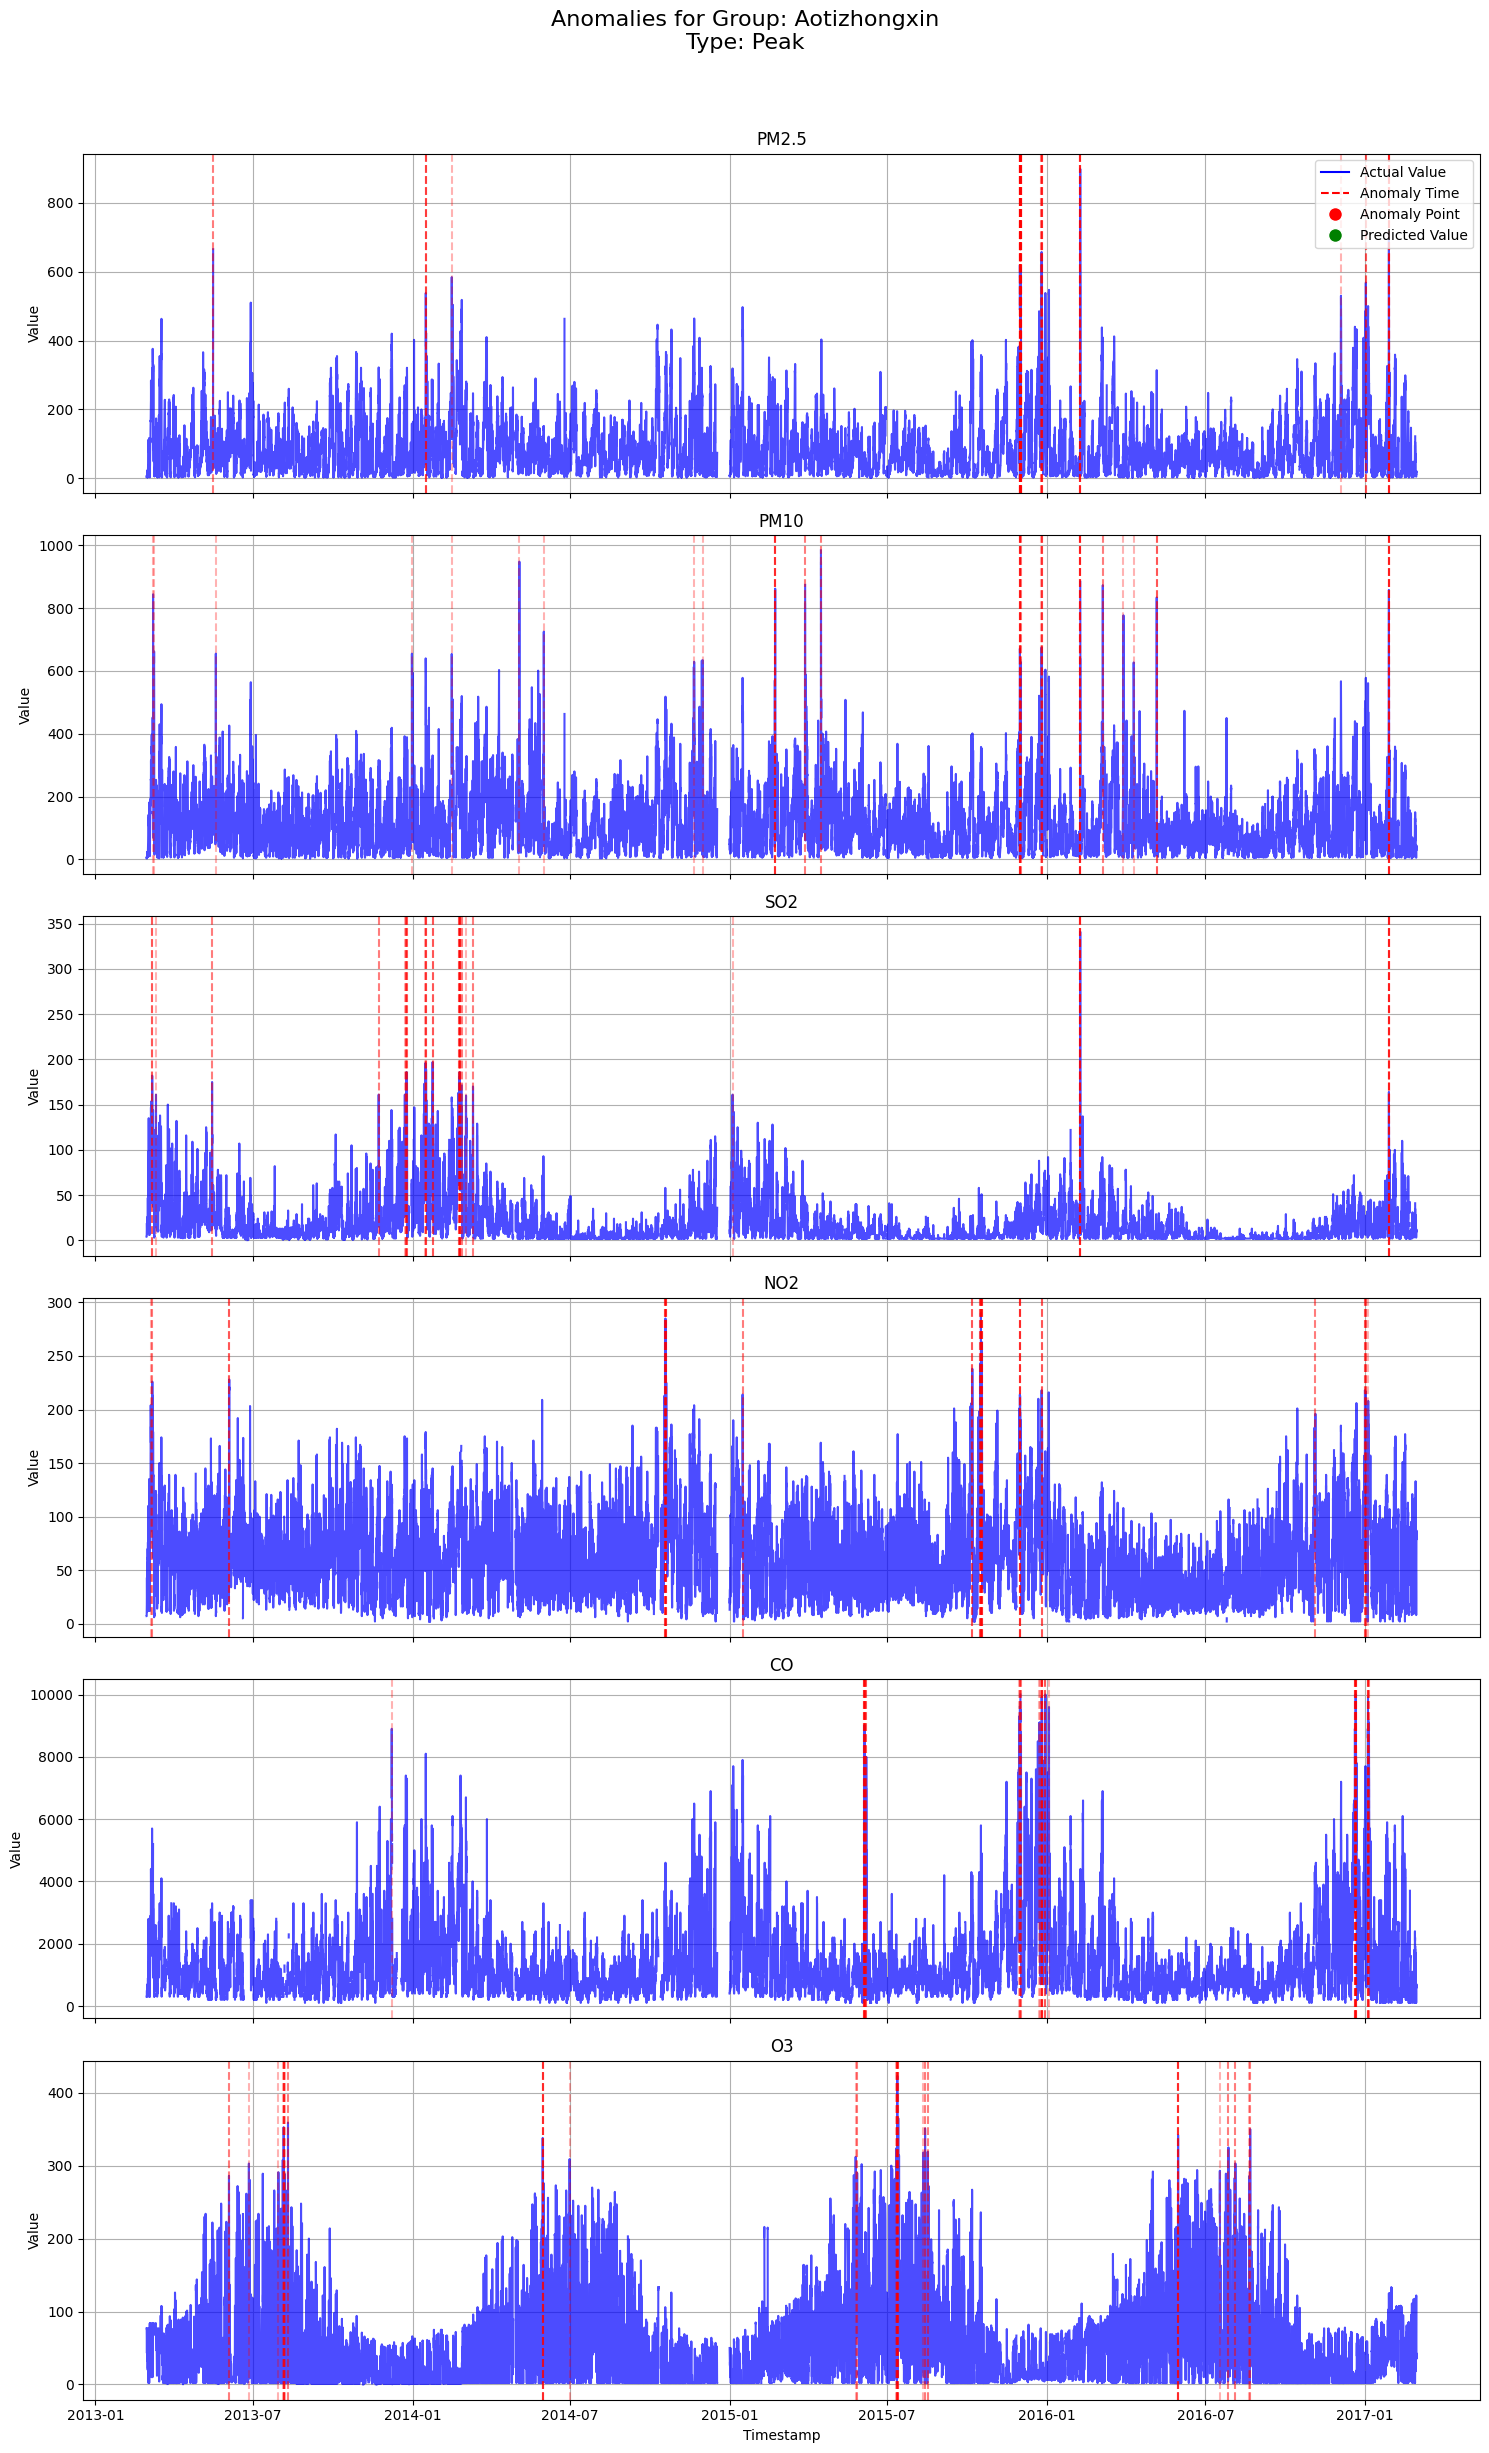

In [16]:
plot_group_anomalies(df, results=results, all_kpis=timeseries_cols, anomaly_type="peak", group_name="Aotizhongxin", timestamps_col=timestamps_col)

## Plot for station="Wanliu"

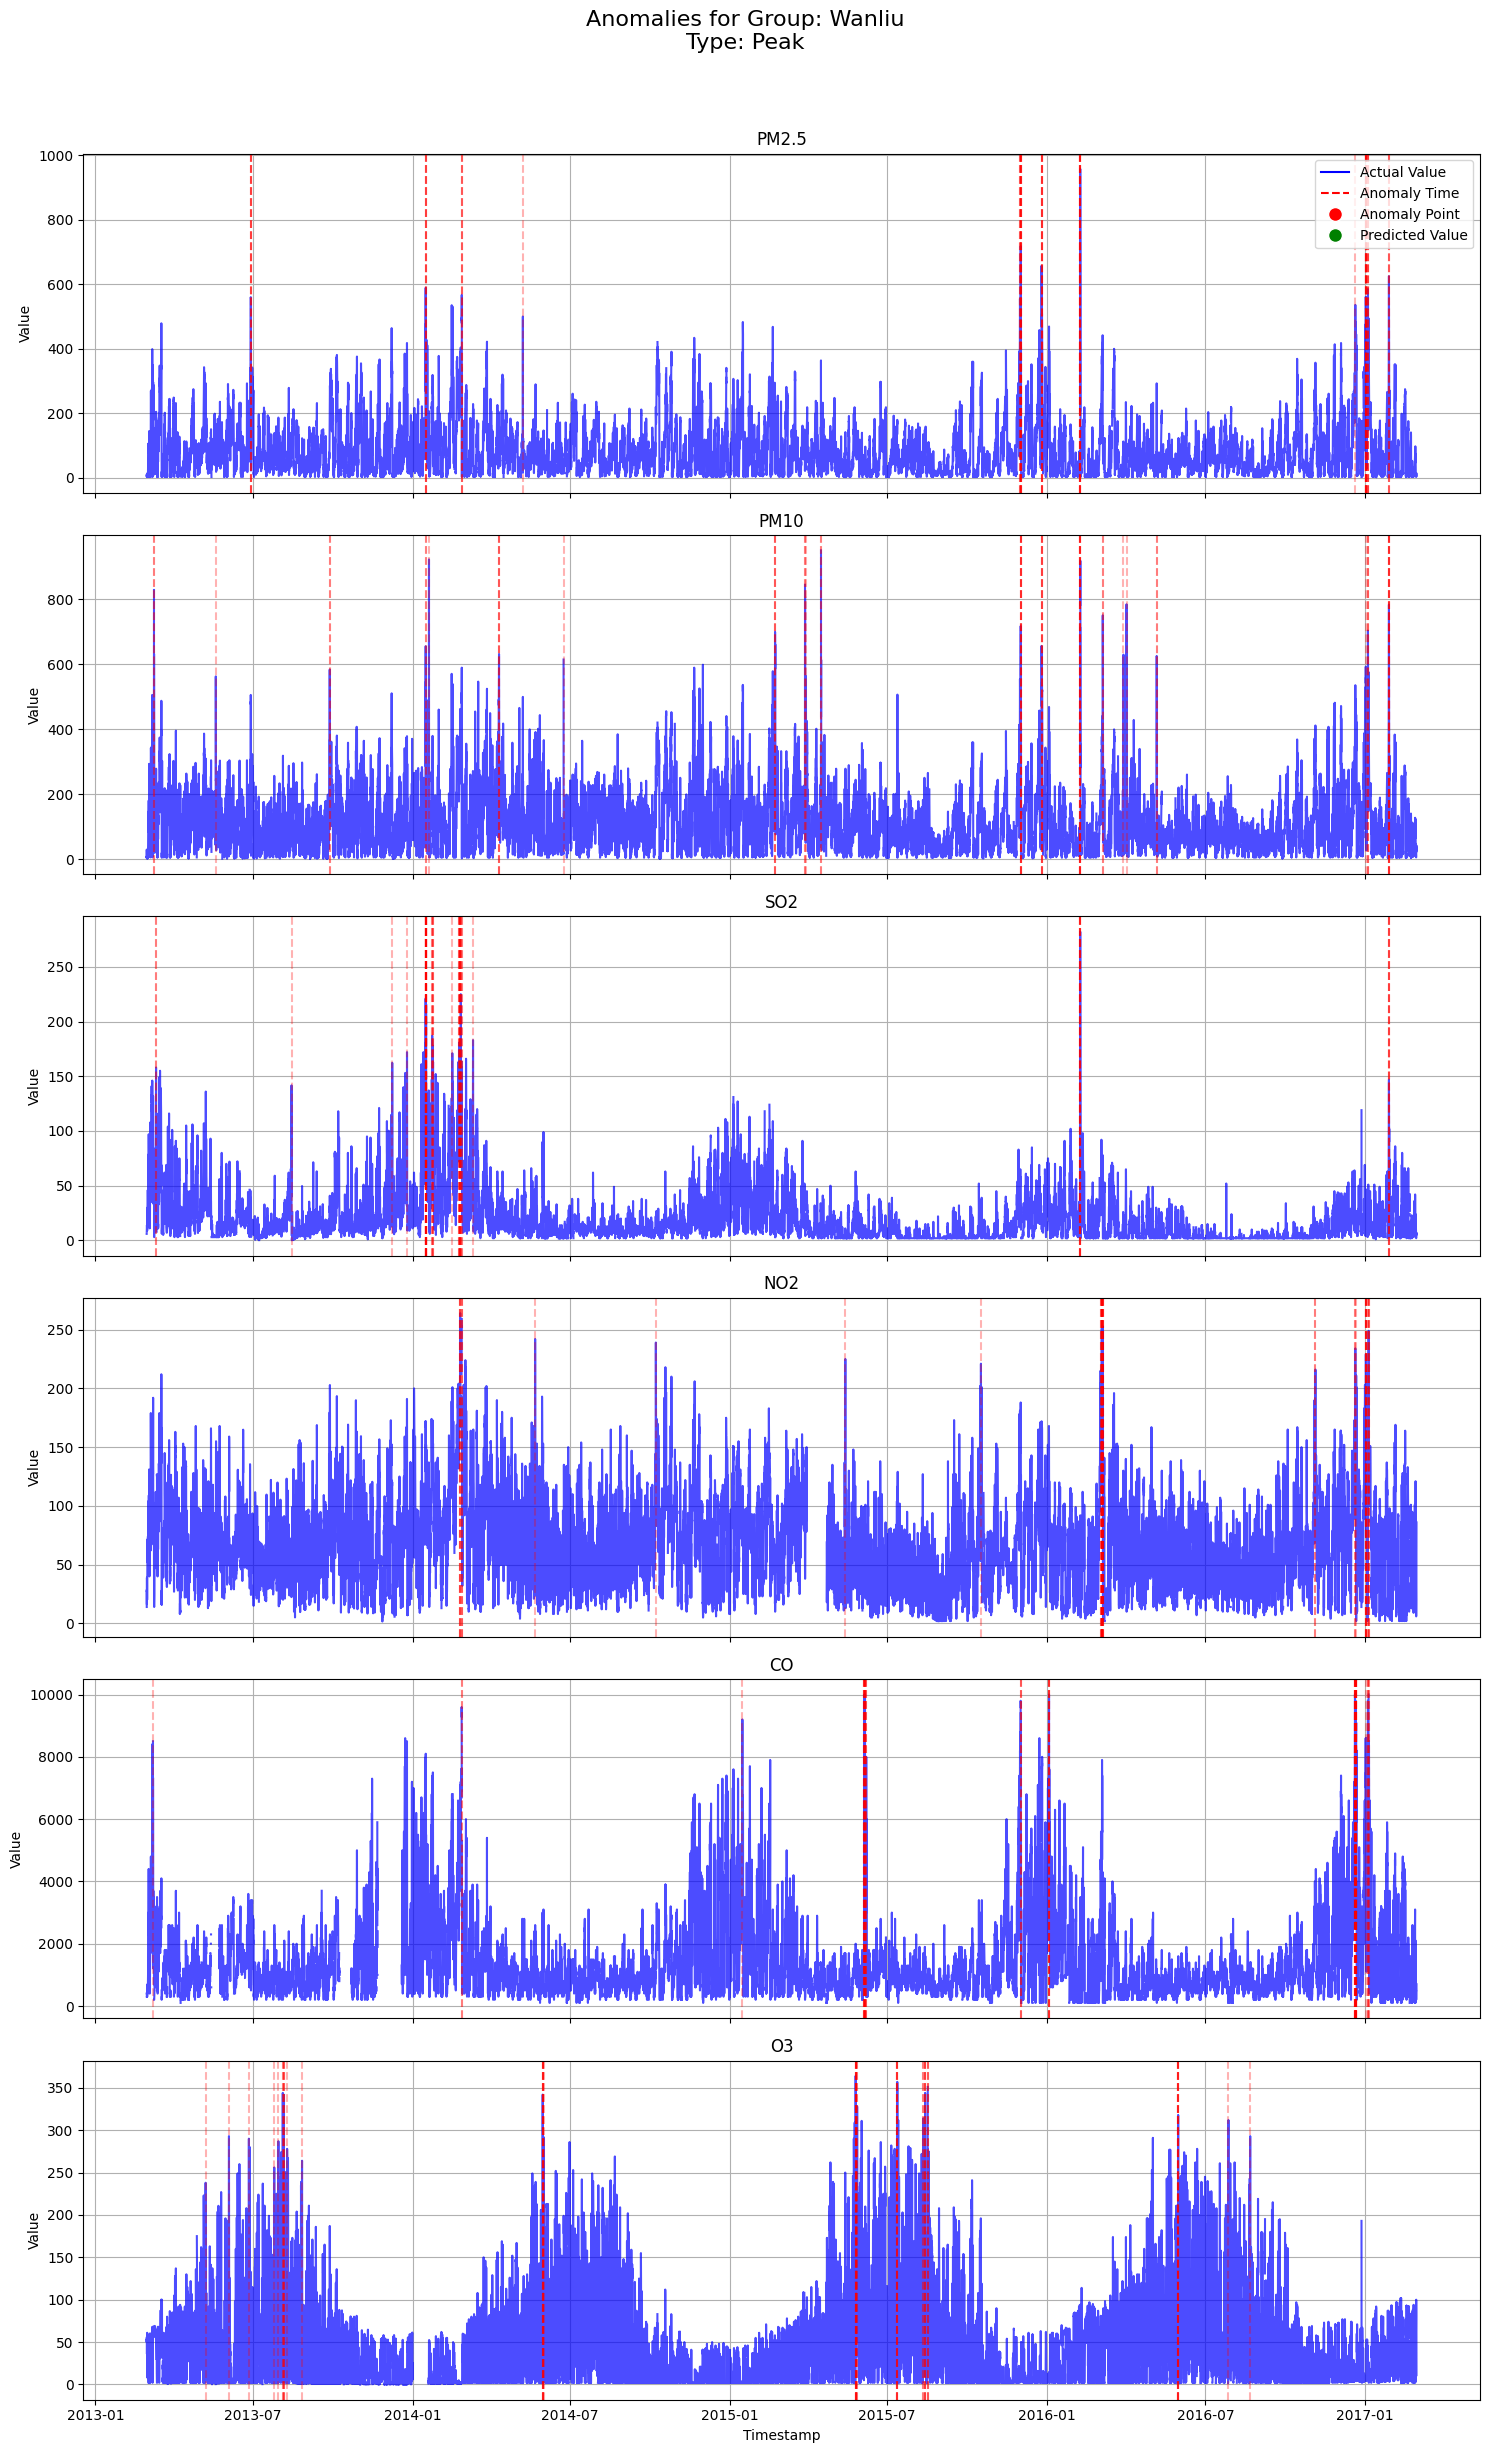

In [17]:
plot_group_anomalies(df, results=results, all_kpis=timeseries_cols, anomaly_type="peak", group_name="Wanliu", timestamps_col=timestamps_col)

## Plot for station="Tiantan"

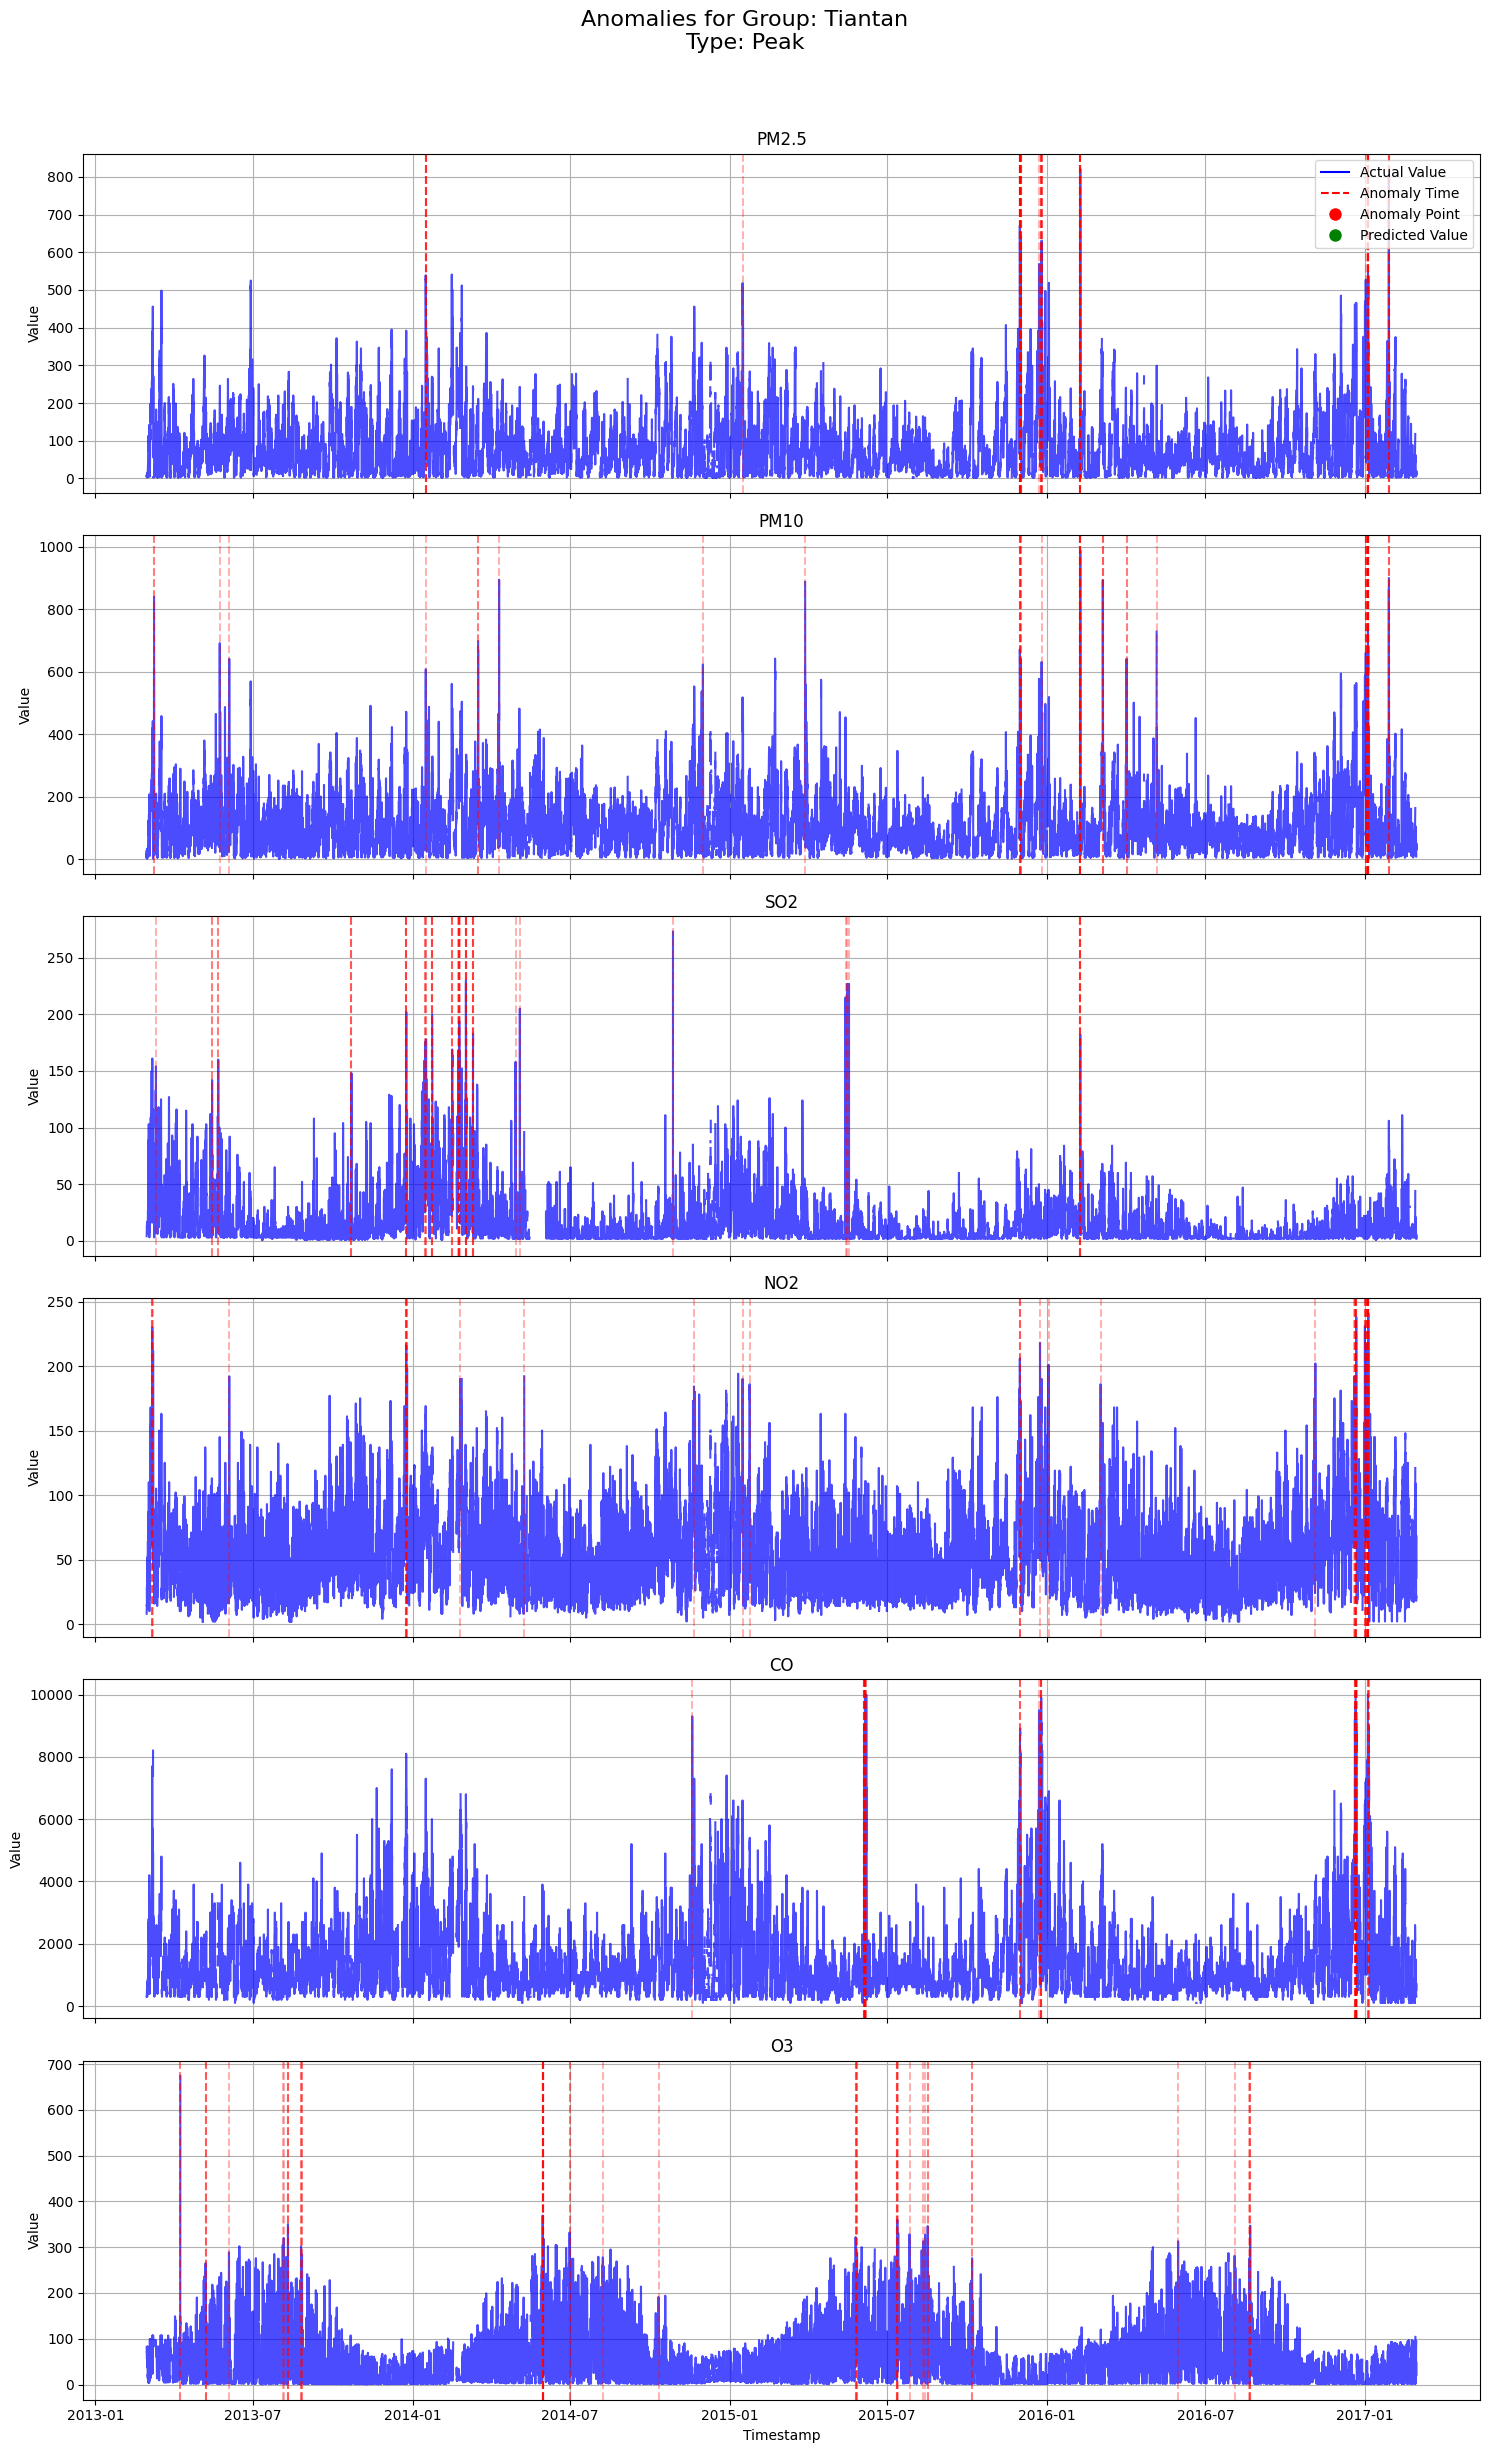

In [18]:
plot_group_anomalies(df, results=results, all_kpis=timeseries_cols, anomaly_type="peak", group_name="Tiantan", timestamps_col=timestamps_col)